In [80]:
#importing the required libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import seaborn as sns


In [81]:
#loading the data into csv file and storing it in a dataframe
df = pd.read_csv('data_01.12.2020.csv')

In [82]:
len(df)

423466

In [83]:
#checking for duplicate values
df.duplicated(subset = None, keep = 'first').any()


True

In [84]:
#dropping the duplicate data
df.drop_duplicates(inplace=True)

In [85]:
#checking the number of null values present in each column
df.isna().sum()



sales_date                1
first_registration      233
channel                   0
brand                     1
model                     1
modelyear                 1
fuel                      1
listprice                 1
mileage                   1
region                15780
sales_price               1
dtype: int64

In [86]:
#In 'region' column there are 15780 null values,instead of dropping the null values for this column the missing values 
#are considered as a seperate group
df["region"].fillna("No Region", inplace = True)

#Dropping the null values in other columns excluding 'region' as they are few
df.dropna(how='any', inplace=True)


In [87]:
df.isna().sum()

sales_date            0
first_registration    0
channel               0
brand                 0
model                 0
modelyear             0
fuel                  0
listprice             0
mileage               0
region                0
sales_price           0
dtype: int64

In [88]:
#dropping the channel column as the value is same for all the data

df['channel'].value_counts()


O    423232
Name: channel, dtype: int64

In [89]:
df.drop(columns=['channel'],inplace = True)


In [90]:
#converting brand(volkswagen) in uppercase to lowercase as they both are similar

df['brand'].value_counts()

Volkswagen    276189
Audi          146789
VOLKSWAGEN       254
Name: brand, dtype: int64

In [91]:
df['brand']=df['brand'].str.lower()
df['brand'].value_counts()

volkswagen    276443
audi          146789
Name: brand, dtype: int64

In [92]:
#converting the datatype of listprice,sales_price,sales_date,first_registration to numeric and sales_date,first_registration to date type

df['sales_price'] = df['sales_price'].str.replace('$', '')
df['sales_price'] = df['sales_price'].str.replace(',', '')
df['listprice'] = df['listprice'].str.replace('$', '')
df['listprice'] = df['listprice'].str.replace(',', '')
df['sales_price'] = pd.to_numeric(df['sales_price'])
df['listprice'] = pd.to_numeric(df['listprice'])
df['sales_date']=pd.to_datetime(df['sales_date'])
df['first_registration']=pd.to_datetime(df['first_registration'])
df

,sales_date,first_registration,brand,model,modelyear,fuel,listprice,mileage,region,sales_price
0,2017-01-01,2014-02-28,volkswagen,JETTA (A6),2014.0,G,24255,15986.0,Southeast,11800
1,2017-01-01,2014-05-30,volkswagen,JETTA (A6),2014.0,G,22905,7123.0,Pacific,10739
2,2017-01-01,2013-06-30,audi,A4 Sedan,2013.0,G,54165,28765.0,Pacific,28707
3,2017-01-01,2013-01-19,volkswagen,Passat,2013.0,G,24010,50415.0,Pacific,9376
4,2017-01-01,2014-03-20,volkswagen,JETTA (A6),2014.0,G,24585,35325.0,Northeast,10500
...,...,...,...,...,...,...,...,...,...,...
423460,2019-04-30,2017-03-11,audi,A4 Sedan,2017.0,G,48775,15241.0,No Region,24800
423461,2019-04-30,2018-06-29,volkswagen,TIGUAN,2018.0,G,23150,13176.0,No Region,12600
423462,2019-04-30,2018-03-15,volkswagen,TIGUAN,2017.0,G,26995,44045.0,No Region,12000
423463,2019-04-30,2018-03-23,volkswagen,TIGUAN,2017.0,G,27025,18601.0,Midwest,14600


In [93]:
df.dtypes

sales_date            datetime64[ns]
first_registration    datetime64[ns]
brand                         object
model                         object
modelyear                    float64
fuel                          object
listprice                      int64
mileage                      float64
region                        object
sales_price                    int64
dtype: object

In [94]:
df

,sales_date,first_registration,brand,model,modelyear,fuel,listprice,mileage,region,sales_price
0,2017-01-01,2014-02-28,volkswagen,JETTA (A6),2014.0,G,24255,15986.0,Southeast,11800
1,2017-01-01,2014-05-30,volkswagen,JETTA (A6),2014.0,G,22905,7123.0,Pacific,10739
2,2017-01-01,2013-06-30,audi,A4 Sedan,2013.0,G,54165,28765.0,Pacific,28707
3,2017-01-01,2013-01-19,volkswagen,Passat,2013.0,G,24010,50415.0,Pacific,9376
4,2017-01-01,2014-03-20,volkswagen,JETTA (A6),2014.0,G,24585,35325.0,Northeast,10500
...,...,...,...,...,...,...,...,...,...,...
423460,2019-04-30,2017-03-11,audi,A4 Sedan,2017.0,G,48775,15241.0,No Region,24800
423461,2019-04-30,2018-06-29,volkswagen,TIGUAN,2018.0,G,23150,13176.0,No Region,12600
423462,2019-04-30,2018-03-15,volkswagen,TIGUAN,2017.0,G,26995,44045.0,No Region,12000
423463,2019-04-30,2018-03-23,volkswagen,TIGUAN,2017.0,G,27025,18601.0,Midwest,14600


In [95]:
##number of years the car was used before selling is considered as difference between sales_date and first_registration
#used_days=df1['sales_date']-df1['first_registration']

df['car_usage(D)']=(df['sales_date']-df['first_registration']).dt.days


In [96]:
df['sale_year']=df.sales_date.dt.year
df['sale_month']=df.sales_date.dt.month
df['modelreleased_ago(Y)']=(df['sale_year']-df['modelyear'])

In [46]:
df

,sales_date,first_registration,brand,model,modelyear,fuel,listprice,mileage,region,sales_price,car_usage(D),sale_year,sale_month,modelreleased_ago(Y)
0,2017-01-01,2014-02-28,volkswagen,JETTA (A6),2014.0,G,24255,15986.0,Southeast,11800,1038,2017,1,3.0
1,2017-01-01,2014-05-30,volkswagen,JETTA (A6),2014.0,G,22905,7123.0,Pacific,10739,947,2017,1,3.0
2,2017-01-01,2013-06-30,audi,A4 Sedan,2013.0,G,54165,28765.0,Pacific,28707,1281,2017,1,4.0
3,2017-01-01,2013-01-19,volkswagen,Passat,2013.0,G,24010,50415.0,Pacific,9376,1443,2017,1,4.0
4,2017-01-01,2014-03-20,volkswagen,JETTA (A6),2014.0,G,24585,35325.0,Northeast,10500,1018,2017,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423460,2019-04-30,2017-03-11,audi,A4 Sedan,2017.0,G,48775,15241.0,No Region,24800,780,2019,4,2.0
423461,2019-04-30,2018-06-29,volkswagen,TIGUAN,2018.0,G,23150,13176.0,No Region,12600,305,2019,4,1.0
423462,2019-04-30,2018-03-15,volkswagen,TIGUAN,2017.0,G,26995,44045.0,No Region,12000,411,2019,4,2.0
423463,2019-04-30,2018-03-23,volkswagen,TIGUAN,2017.0,G,27025,18601.0,Midwest,14600,403,2019,4,2.0


In [47]:
df.dtypes

sales_date              datetime64[ns]
first_registration      datetime64[ns]
brand                           object
model                           object
modelyear                      float64
fuel                            object
listprice                        int64
mileage                        float64
region                          object
sales_price                      int64
car_usage(D)                     int64
sale_year                        int64
sale_month                       int64
modelreleased_ago(Y)           float64
dtype: object

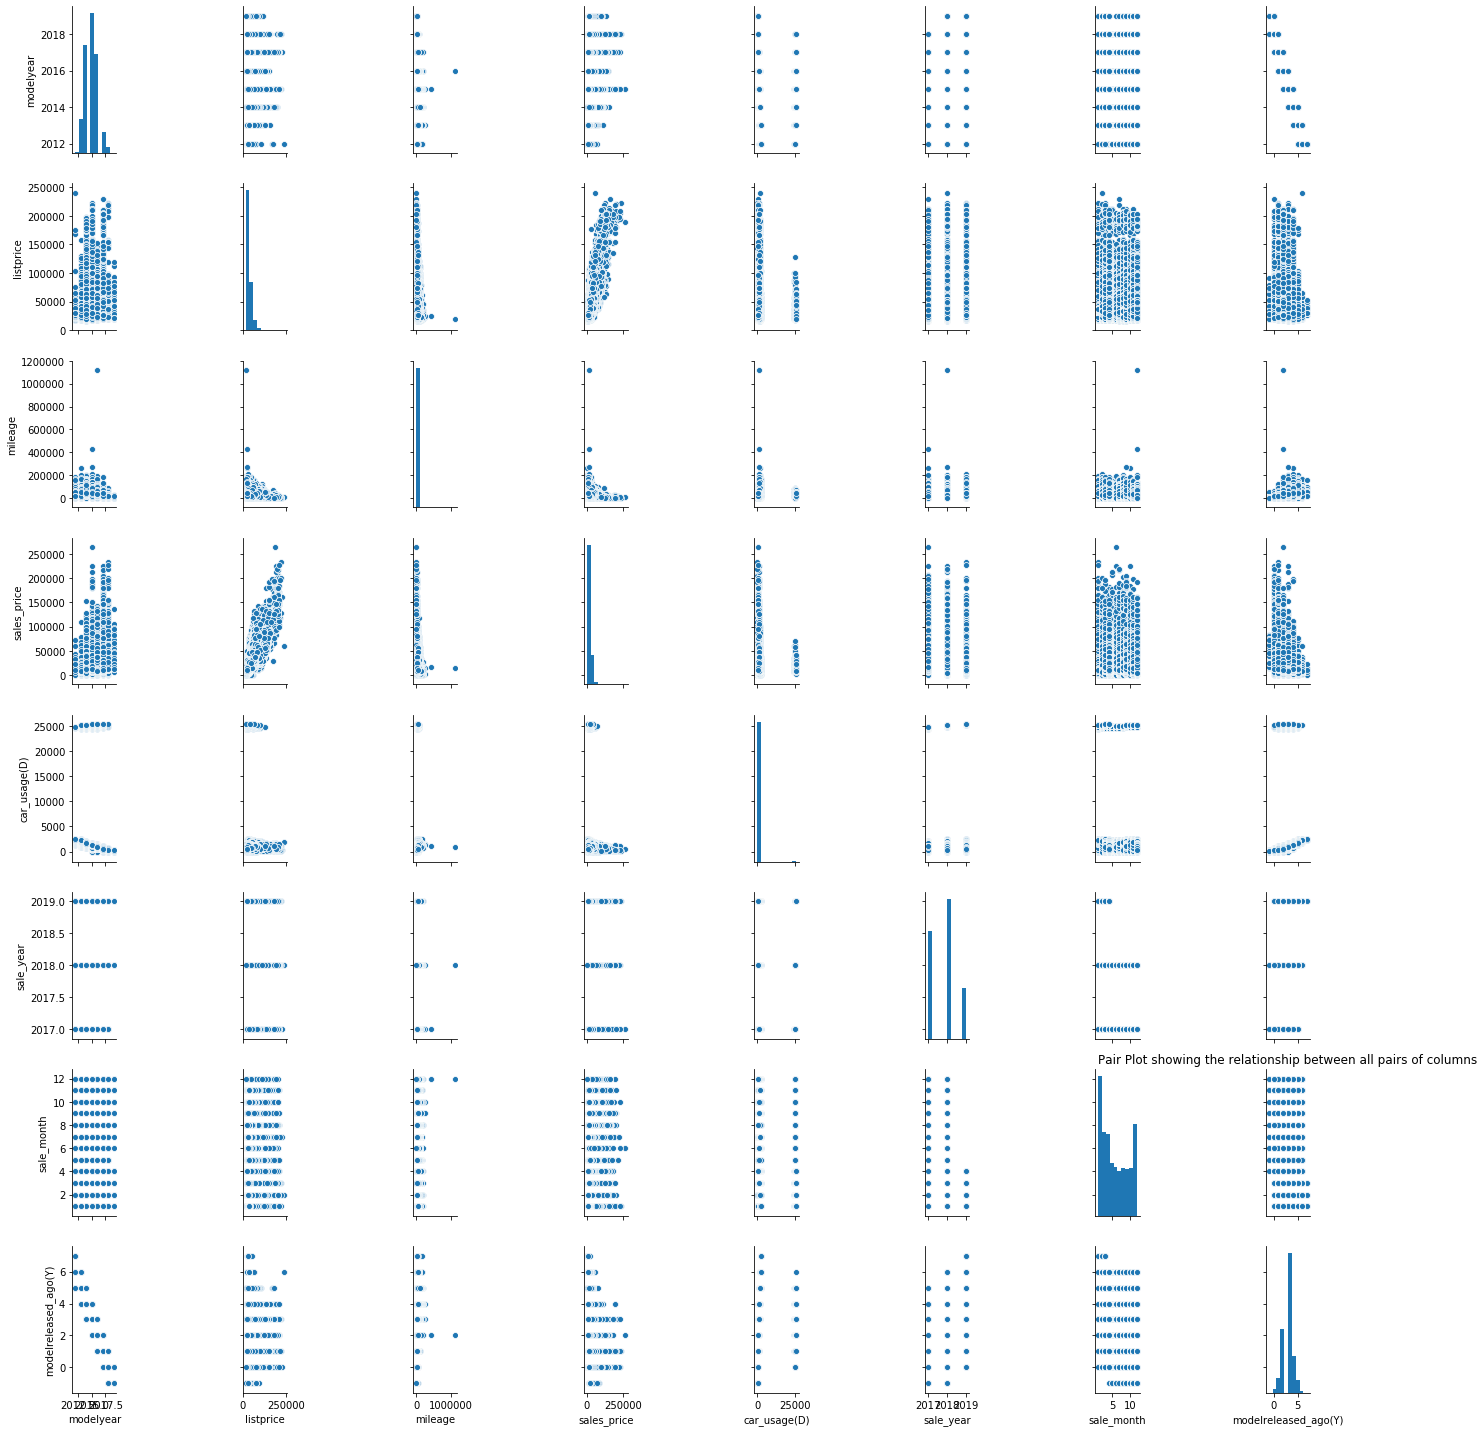

In [48]:
#Visualization
#plotting the relationship between pair of columns in the dataframe
sns.pairplot(df)
plt.title('Pair Plot showing the relationship between all pairs of columns')
plt.tight_layout()
plt.show()


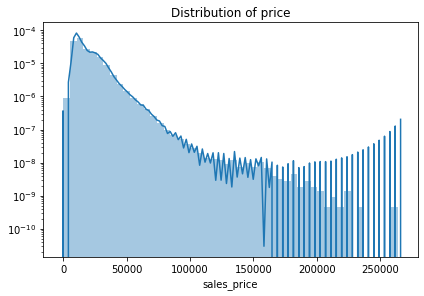

In [49]:
ax=sns.distplot(df.sales_price)
ax.set_yscale('log')
plt.tight_layout()
plt.title("Distribution of price")
plt.show()


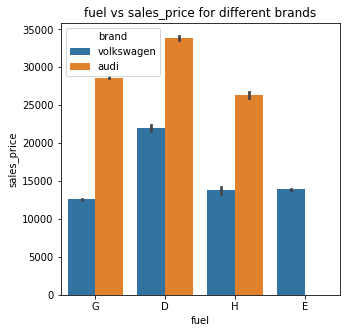

In [50]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='fuel',y='sales_price',hue='brand',data=df,ax=axs)
axs.set_title('fuel vs sales_price for different brands')
plt.show()

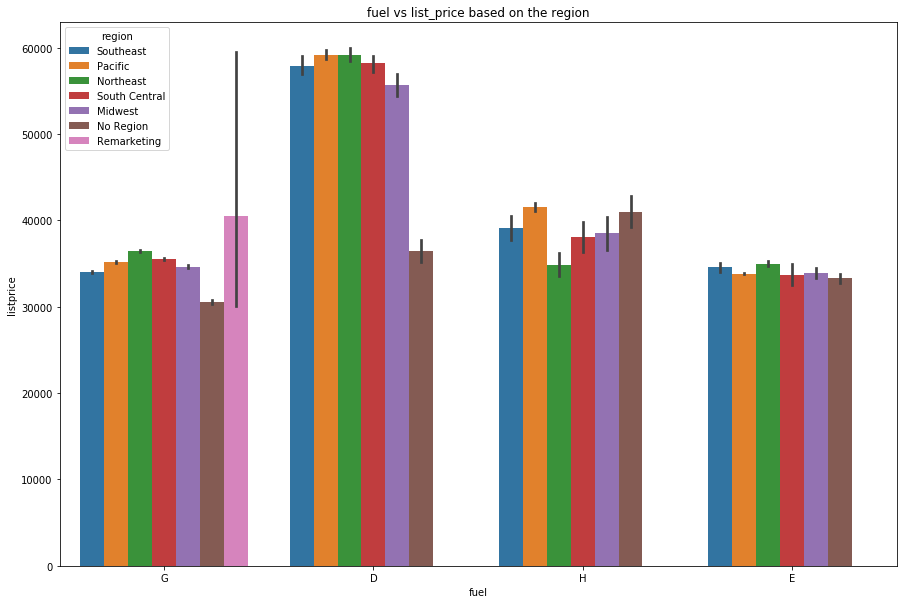

In [51]:
fig,axs=plt.subplots()
fig.set_size_inches(15,10)

p1=sns.barplot(x='fuel',y='listprice',hue='region',data=df,ax=axs)
axs.set_title('fuel vs list_price based on the region')
plt.show()

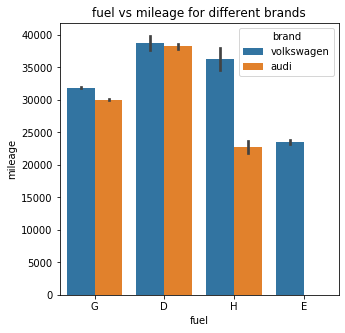

In [52]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)
p1=sns.barplot(x='fuel',y='mileage',hue='brand',data=df,ax=axs)
axs.set_title('fuel vs mileage for different brands')
plt.show()

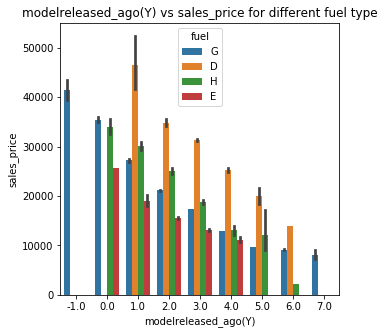

In [53]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)
p1=sns.barplot(x='modelreleased_ago(Y)',y='sales_price',hue='fuel',data=df,ax=axs)
axs.set_title('modelreleased_ago(Y) vs sales_price for different fuel type')
plt.show()

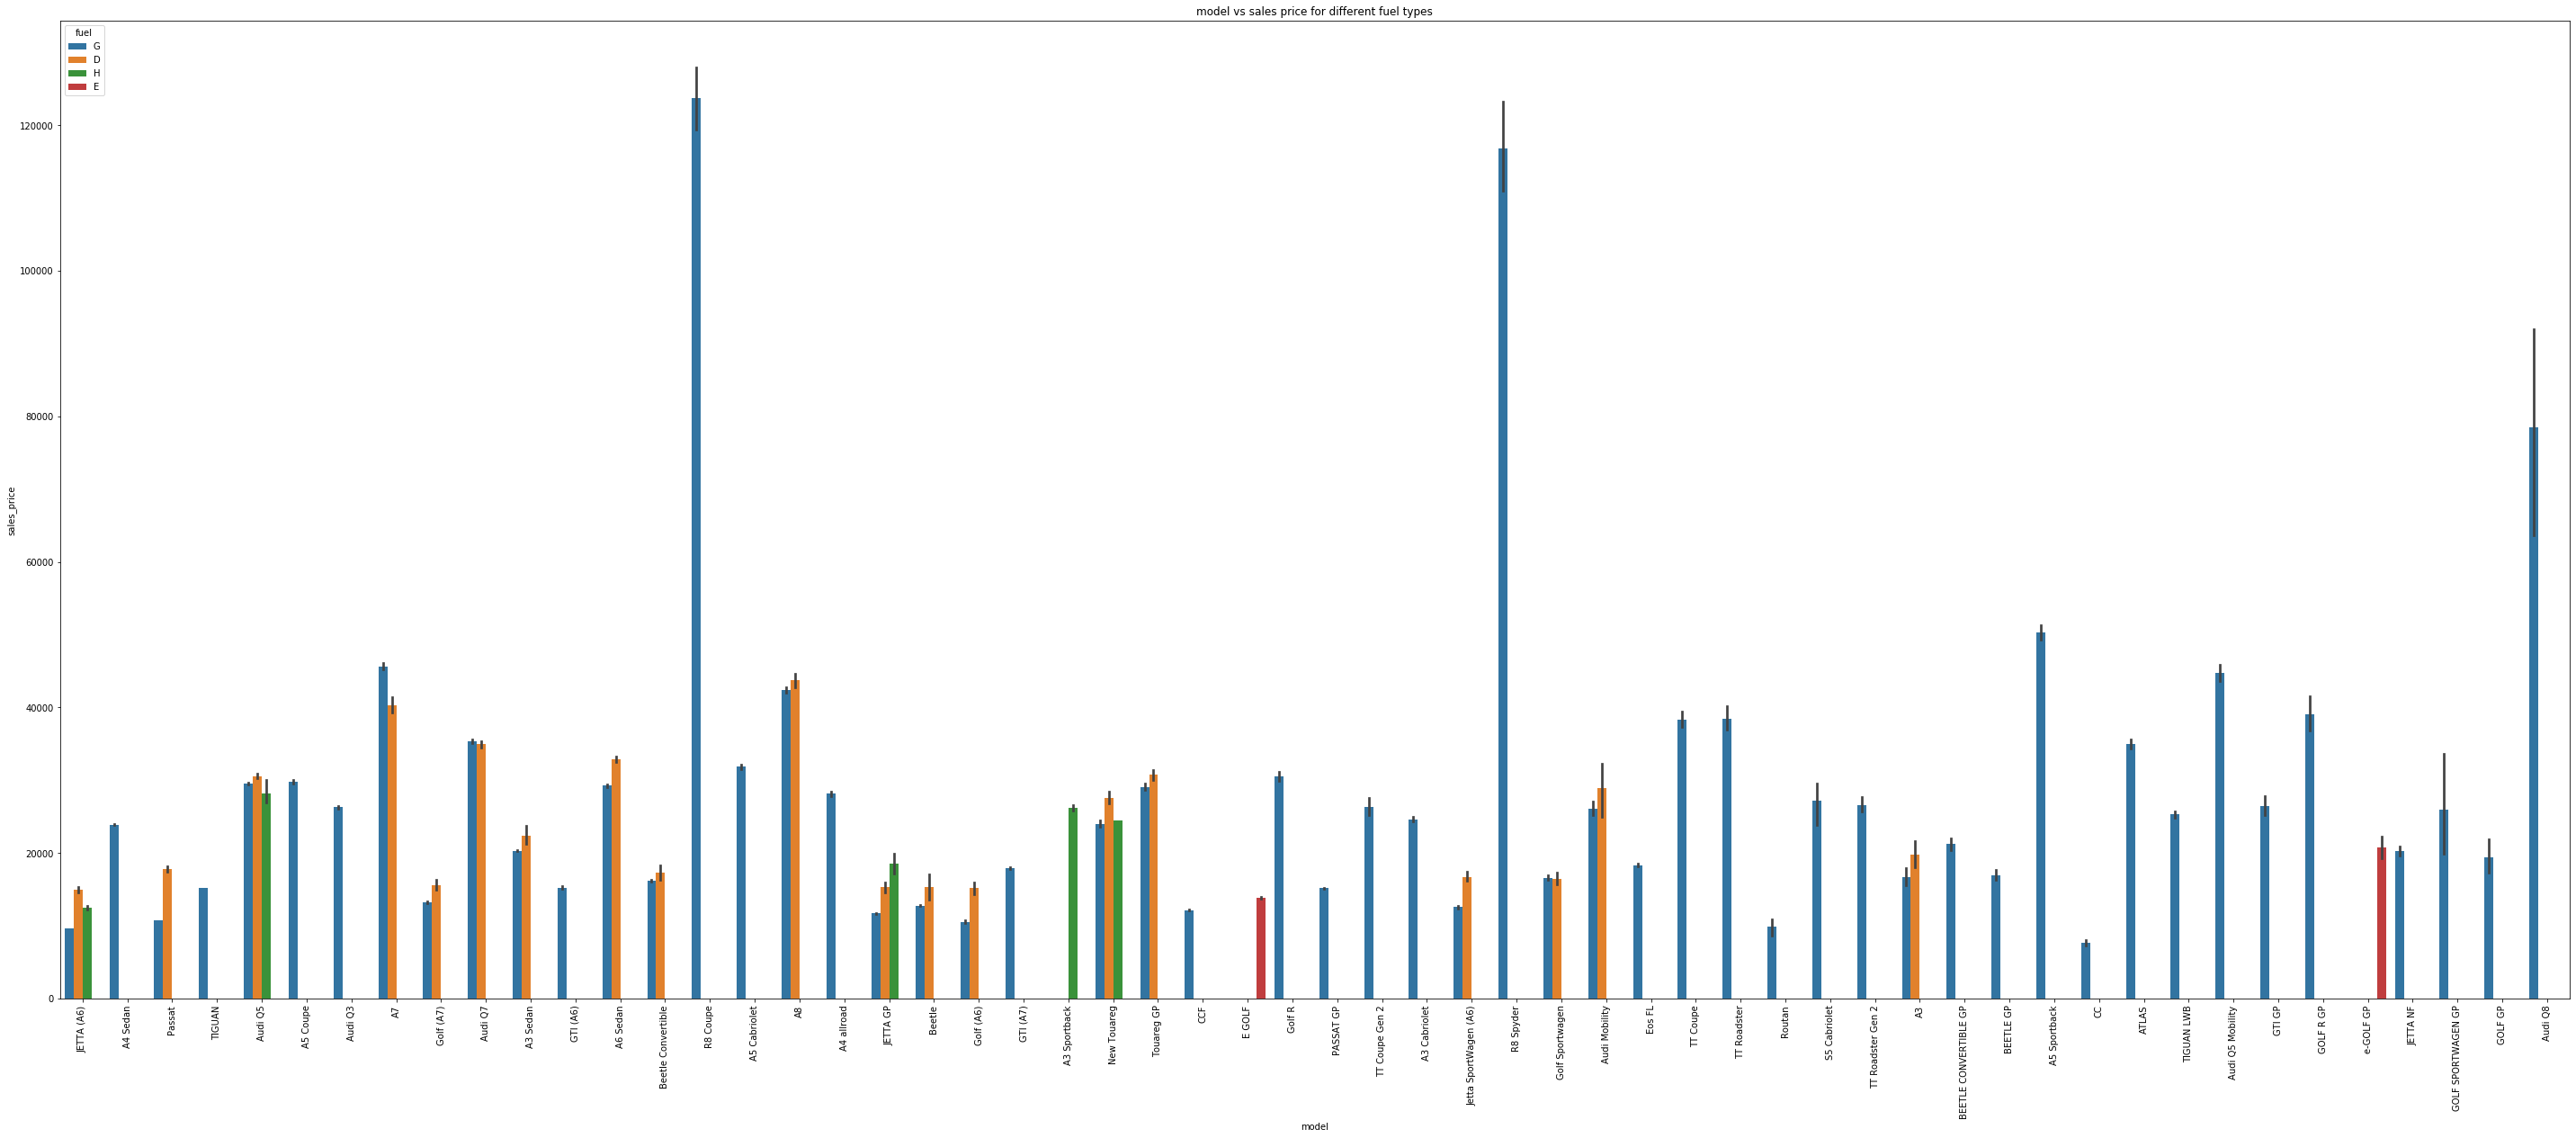

In [56]:
plt.figure(figsize=(50,20))
sns.barplot(x='model',y='sales_price',hue='fuel',data=df)
plt.title('model vs sales price for different fuel types')
plt.xticks(rotation=90)
plt.show()

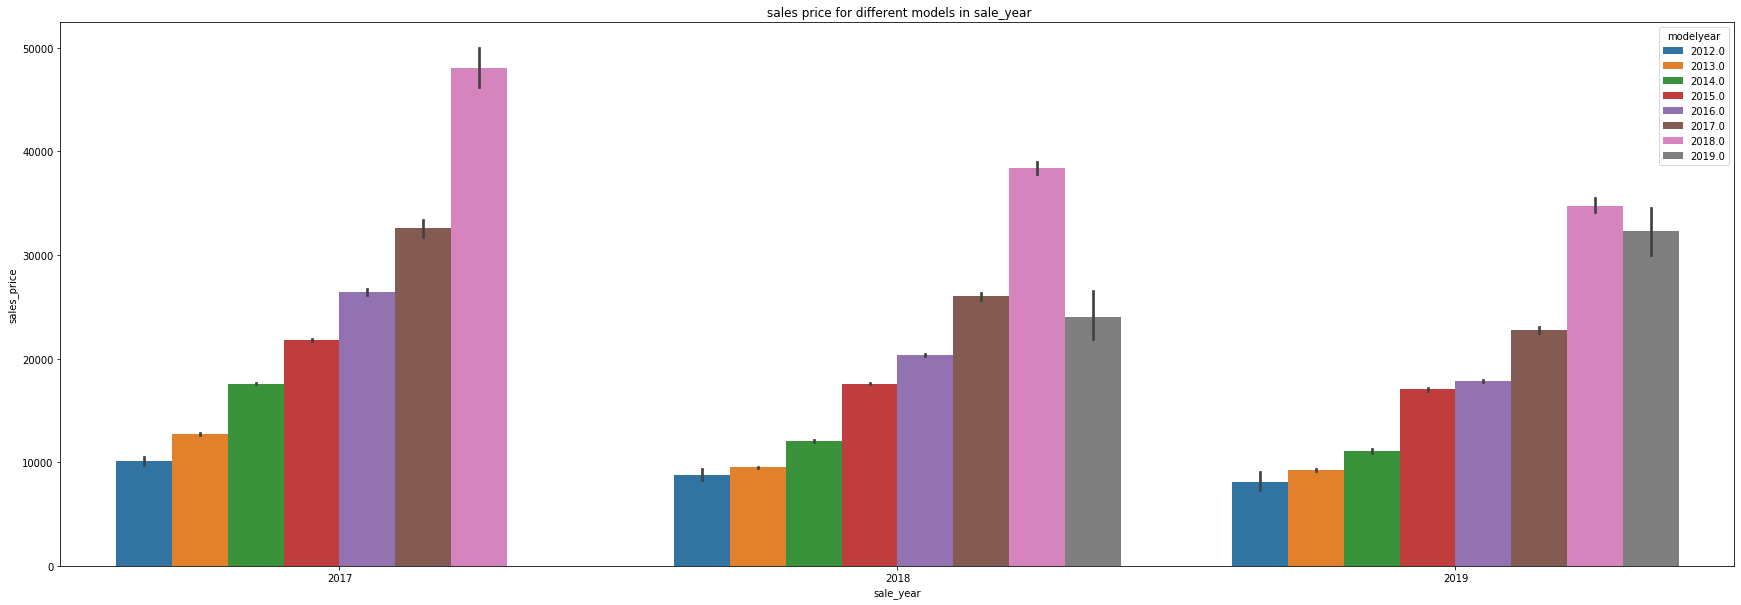

In [54]:
plt.figure(figsize=(30,10))
sns.barplot(x='sale_year',y='sales_price',hue='modelyear',data=df)
plt.title(' sales price for different models in sale_year')
plt.show()

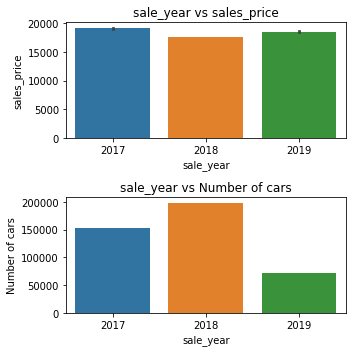

In [55]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(5,5)
sns.barplot(x='sale_year',y='sales_price',data=df,ax=axs[0])
sns.barplot(df.groupby('sale_year').count()['sales_price'].index,df.groupby('sale_year').count()['sales_price'].values,ax=axs[1])
axs[0].set_title('sale_year vs sales_price')
axs[1].set_title('sale_year vs Number of cars')
axs[1].set_ylabel('Number of cars')
plt.tight_layout()
plt.show()



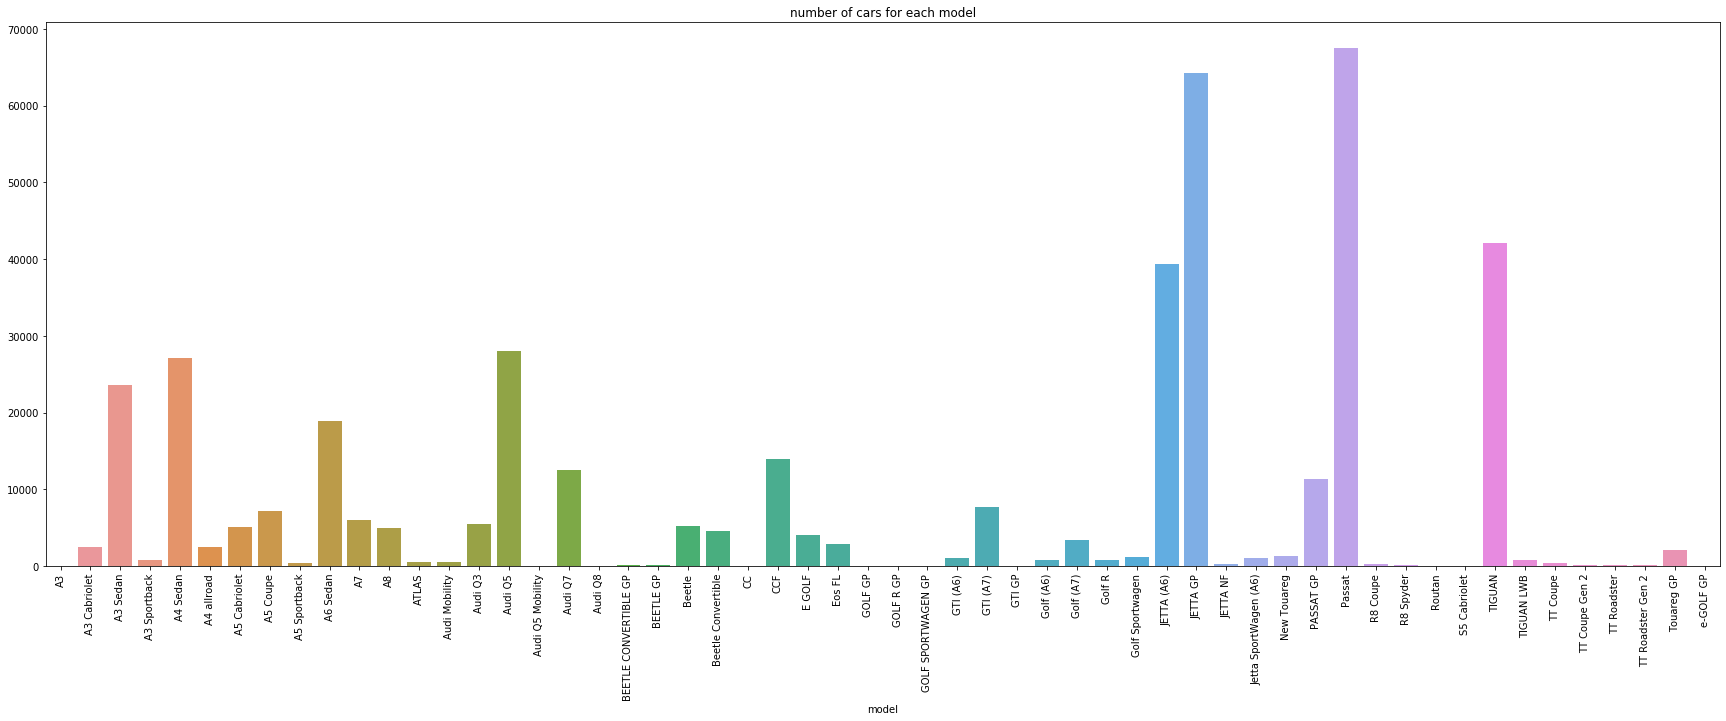

In [57]:
plt.figure(figsize=(30,10))
sns.barplot(df.groupby('model').count().index,df.groupby('model').count()['brand'].values)
plt.xticks(rotation=90)
plt.title('number of cars for each model')
plt.show()

In [98]:
#scaling the numeric columns
df['listprice']=preprocessing.scale(df['listprice'])
df['mileage']=preprocessing.scale(df['mileage'])
df['sales_price']=preprocessing.scale(df['sales_price'])

In [99]:
#encoding categorical variables to numeric values 
df1=pd.get_dummies(df['fuel'],drop_first=True )
df2=pd.get_dummies(df['brand'],drop_first=True )
df3=pd.get_dummies(df['model'],drop_first=True )
df=pd.concat([df,df1,df2,df3],axis=1)
df


,sales_date,first_registration,brand,model,modelyear,fuel,listprice,mileage,region,sales_price,...,Routan,S5 Cabriolet,TIGUAN,TIGUAN LWB,TT Coupe,TT Coupe Gen 2,TT Roadster,TT Roadster Gen 2,Touareg GP,e-GOLF GP
0,2017-01-01,2014-02-28,volkswagen,JETTA (A6),2014.0,G,-0.692366,-1.038830,Southeast,-0.572345,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,2014-05-30,volkswagen,JETTA (A6),2014.0,G,-0.775891,-1.641134,Pacific,-0.666265,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,2013-06-30,audi,A4 Sedan,2013.0,G,1.158170,-0.170405,Pacific,0.924265,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,2013-01-19,volkswagen,Passat,2013.0,G,-0.707524,1.300868,Pacific,-0.786917,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-01,2014-03-20,volkswagen,JETTA (A6),2014.0,G,-0.671949,0.275394,Northeast,-0.687421,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423460,2019-04-30,2017-03-11,audi,A4 Sedan,2017.0,G,0.824690,-1.089458,No Region,0.578417,...,0,0,0,0,0,0,0,0,0,0
423461,2019-04-30,2018-06-29,volkswagen,TIGUAN,2018.0,G,-0.760733,-1.229789,No Region,-0.501529,...,0,0,1,0,0,0,0,0,0,0
423462,2019-04-30,2018-03-15,volkswagen,TIGUAN,2017.0,G,-0.522842,0.867980,No Region,-0.554641,...,0,0,1,0,0,0,0,0,0,0
423463,2019-04-30,2018-03-23,volkswagen,TIGUAN,2017.0,G,-0.520986,-0.861122,Midwest,-0.324488,...,0,0,1,0,0,0,0,0,0,0


In [100]:
df.corr()

,modelyear,listprice,mileage,sales_price,car_usage(D),sale_year,sale_month,modelreleased_ago(Y),E,G,...,Routan,S5 Cabriolet,TIGUAN,TIGUAN LWB,TT Coupe,TT Coupe Gen 2,TT Roadster,TT Roadster Gen 2,Touareg GP,e-GOLF GP
modelyear,1.000000,0.121045,-0.298668,0.312252,-0.301871,0.481874,0.010578,-0.777196,0.046768,0.006444,...,-0.010928,-0.007154,0.090315,0.121640,0.041016,-0.010542,0.021323,-0.003937,0.042136,0.013138
listprice,0.121045,1.000000,-0.034287,0.845207,-0.029123,0.006542,0.000187,-0.131265,-0.009269,-0.138659,...,-0.000192,0.005041,-0.097353,-0.014353,0.035377,0.014162,0.019565,0.011216,0.085884,-0.000414
mileage,-0.298668,-0.034287,1.000000,-0.186822,0.151691,0.000886,-0.003622,0.336114,-0.052010,-0.016177,...,0.008774,0.000240,-0.018093,-0.062482,-0.029771,-0.007672,-0.016829,-0.007645,0.006548,-0.010355
sales_price,0.312252,0.845207,-0.186822,1.000000,-0.132145,-0.032944,0.024674,-0.374395,-0.037902,-0.094382,...,-0.003032,0.002108,-0.090374,0.026999,0.056227,0.013769,0.030451,0.009787,0.070384,0.001472
car_usage(D),-0.301871,-0.029123,0.151691,-0.132145,1.000000,0.028293,-0.000867,0.359394,-0.011596,-0.000249,...,0.002675,0.002291,-0.028087,-0.047298,-0.014902,0.000694,-0.006571,0.000443,-0.012218,-0.006716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TT Coupe Gen 2,-0.010542,0.014162,-0.007672,0.013769,0.000694,-0.019722,-0.005970,-0.002321,-0.001887,0.003389,...,-0.000078,-0.000051,-0.006403,-0.000837,-0.000609,1.000000,-0.000328,-0.000256,-0.001357,-0.000129
TT Roadster,0.021323,0.019565,-0.016829,0.030451,-0.006571,0.010776,0.001787,-0.016212,-0.001670,0.003000,...,-0.000069,-0.000045,-0.005667,-0.000741,-0.000539,-0.000328,1.000000,-0.000227,-0.001201,-0.000114
TT Roadster Gen 2,-0.003937,0.011216,-0.007645,0.009787,0.000443,-0.013045,-0.000167,-0.004947,-0.001304,0.002342,...,-0.000054,-0.000035,-0.004425,-0.000578,-0.000421,-0.000256,-0.000227,1.000000,-0.000938,-0.000089
Touareg GP,0.042136,0.085884,0.006548,0.070384,-0.012218,0.024143,0.010181,-0.029991,-0.006901,-0.099760,...,-0.000287,-0.000188,-0.023421,-0.003061,-0.002229,-0.001357,-0.001201,-0.000938,1.000000,-0.000472


In [103]:

df = df.drop(df[(df['car_usage(D)'] <= 0) | (df['modelreleased_ago(Y)'] <= 0)|(df['sales_price']>df['listprice'])].index)

In [104]:
df.drop(columns=['brand','region','sales_date','first_registration','model','modelyear','fuel'],inplace=True)

In [105]:
##splitting into train data(data until march 2019) and test data(only april 2019) is considered
train_df=df.loc[(df['sale_month']!=4)&(df['sale_year']!=2019)]
test_df=df.loc[(df['sale_year']==2019)&(df['sale_month']==4)]




In [106]:
train_df.dtypes

listprice            float64
mileage              float64
sales_price          float64
car_usage(D)           int64
sale_year              int64
                      ...   
TT Coupe Gen 2         uint8
TT Roadster            uint8
TT Roadster Gen 2      uint8
Touareg GP             uint8
e-GOLF GP              uint8
Length: 66, dtype: object

In [107]:
X_train=train_df.drop(columns=['sales_price','sale_year','sale_month'])
y_train=train_df['sales_price']
X_test=test_df.drop(columns=['sales_price','sale_year','sale_month'])
y_test=test_df['sales_price']

In [108]:
#giving the data to XGBoost regressor model

In [109]:
xg_reg = xgb.XGBRegressor(min_child_weight=15,tree_method='hist',n_estimators=600,reg_alpha=10,gamma=5,max_depth=20,
                          reg_lambda=15,learning_rate=0.25)
xg_reg.fit(X_train,y_train)




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=20,
             min_child_weight=15, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=15, scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)

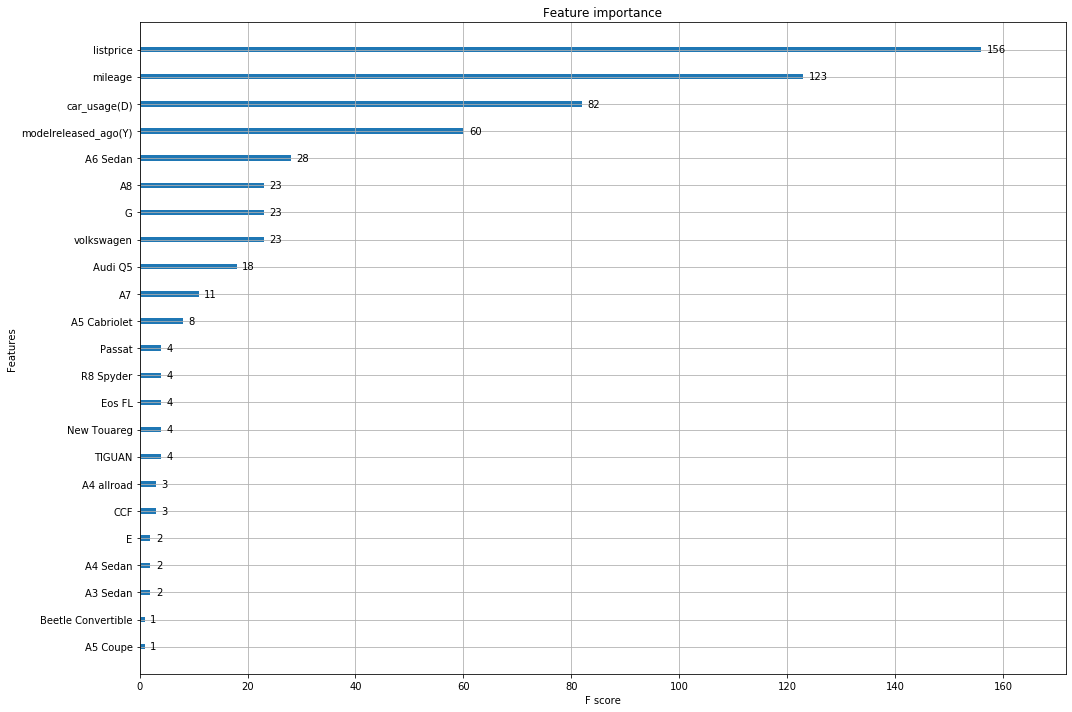

In [110]:
#plotting the feature importance
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.tight_layout()
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show()



In [112]:
#metrics on train data
y_pred = xg_reg.predict(X_train)
r2=r2_score(y_train,y_pred)
mse=mean_squared_error(y_train,y_pred)
mae=mean_absolute_error(y_train,y_pred)

In [113]:
r2

0.968109070588444

In [114]:
mse

0.024644680663290657

In [115]:
mae

0.10270897395501019

In [116]:
#metrics on test data

In [117]:
y_pred = xg_reg.predict(X_test)
r2_test=r2_score(y_test,y_pred)
mse_test=mean_squared_error(y_test,y_pred)
mae_test=mean_absolute_error(y_test,y_pred)

In [118]:
r2_test

0.9252949845195036

In [119]:
mse_test

0.04087000066923005

In [120]:
mae_test

0.14425644993608897